<a href="https://colab.research.google.com/github/sidc124/Alzhimer-Detection/blob/main/_bdf_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's vs. Dementia EEG Classification — End-to-End Deep Learning Pipeline

This notebook implements the full pipeline you described:
1) **Find common channels** across OpenNeuro datasets and align them  
2) **Preprocess** (filtering, referencing, resampling)  
3) **Segment** signals into fixed-size windows and **standardize shapes** (pad/crop)  
4) **Build datasets** and loaders for train/val/test (subject-wise splits)  
5) **Train baselines** (EEGNet) and a **custom hybrid model** that aims to outperform EEGNet  
6) **Evaluate & cross-test** across datasets (train on one, test on the other)  
7) **Result analysis** with metrics and confusion matrices

## 1. Setup & Config

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check available files in one sample folder
!ls "/content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg"

import glob
import os

# Base directory in Google Drive
base_path = "/content/drive/MyDrive/EEG_Project"

# Find all .bdf files (ignore .set)
bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)

print(f"Found {len(bdf_files)} .bdf files")

# Check a few results
print("Example .bdf file:", bdf_files[0] if bdf_files else "None found")


Mounted at /content/drive
sub-hc1_ses-hc_task-rest_channels.tsv  sub-hc1_ses-hc_task-rest_eeg.json
sub-hc1_ses-hc_task-rest_eeg.bdf       sub-hc1_ses-hc_task-rest_events.tsv
Found 46 .bdf files
Example .bdf file: /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf


## 2. Channels finding and common channels

In [2]:
!pip install mne
import mne

# Pick one file from the .bdf dataset
sample_bdf_file = bdf_files[0]

# Load raw data without preprocessing
raw_bdf = mne.io.read_raw_bdf(sample_bdf_file, preload=False)

# Get channel names
channels_bdf = raw_bdf.info["ch_names"]

print("Channels in .bdf dataset:", channels_bdf)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 130.9 MB/s eta 0:00:00
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Channels in .bdf dataset: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']


## 3. reordering the dataset


In [3]:
import mne

# Define common_channels as all channels in the .bdf dataset
common_channels = channels_bdf

# Keep only valid channels in the correct order
ordered_common_channels = [ch for ch in channels_bdf if ch in common_channels]

print("Final channel order:", ordered_common_channels)

# Function to load and reorder channels
def load_and_reorder(filepath, filetype, channel_order):
    if filetype == "bdf":
        raw = mne.io.read_raw_bdf(filepath, preload=True)
    else:
        raise ValueError("Unsupported file type")

    # Pick only common channels and reorder them
    raw.pick_channels(channel_order)
    raw.reorder_channels(channel_order)

    return raw

# Load all .bdf files in the same channel order
all_bdf_data = [load_and_reorder(f, "bdf", ordered_common_channels) for f in bdf_files]

print(f"✅ Loaded {len(all_bdf_data)} .bdf recordings successfully!")


Final channel order: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...)

## 4. checking if the order is same or not


In [4]:
# Check first 3 BDF files to verify channel order
for i, raw_obj in enumerate(all_bdf_data[:3]):
    print(f"\nBDF file {i+1} channels:")
    print(raw_obj.info["ch_names"])

# Compare channel order between all BDF recordings
reference_order = all_bdf_data[0].info["ch_names"]
consistent = all(
    raw_obj.info["ch_names"] == reference_order for raw_obj in all_bdf_data
)

if consistent:
    print("\n✅ All BDF recordings have consistent channel order.")
else:
    print("\n❌ Channel order mismatch detected between some BDF files.")



BDF file 1 channels:
['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

BDF file 2 channels:
['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

BDF file 3 channels:
['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

✅ All BDF recordings have consistent channel order.


##5. checking the sampling freuquency

## 6. Resampling

In [5]:
target_sfreq = 128  # Hz

# Resample .set files
for i, raw in enumerate(all_bdf_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .set file {i+1} to {target_sfreq} Hz")




Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Resampled .set file 1 to 128 Hz
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on

/tmp/ipython-input-2725926239.py:6: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw.resample(target_sfreq)


Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Resampled .set file 22 to 128 Hz
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Resampled .set file 23 to 128 Hz
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the begin

##6. normalization


In [6]:
import numpy as np

# ===== 1️⃣ Shortest recording length =====
min_times = min([raw.n_times for raw in all_bdf_data])
print(f"Minimum common length (time points): {min_times}")

# ===== 2️⃣ Combine dataset =====
X_all = []

for raw in all_bdf_data:
    X_all.append(raw.get_data()[:, :min_times])

X_all = np.array(X_all)  # (n_samples, n_channels, n_times)
print(f"✅ Dataset shape (raw): {X_all.shape}")

# ===== 3️⃣ Normalize per sample, per channel =====
X_scaled = np.zeros_like(X_all, dtype=np.float32)

for i in range(X_all.shape[0]):           # loop over samples
    for ch in range(X_all.shape[1]):      # loop over channels
        ch_data = X_all[i, ch, :]
        mean = np.mean(ch_data)
        std = np.std(ch_data)
        if std > 0:   # avoid divide by zero
            X_scaled[i, ch, :] = (ch_data - mean) / std
        else:
            X_scaled[i, ch, :] = ch_data - mean  # flat channel

print(f"✅ Normalized dataset shape: {X_scaled.shape}")

# ===== 4️⃣ Save ONLY normalized dataset =====
np.save("X_normalized.npy", X_scaled)
np.save('/content/drive/MyDrive/X_normalized.npy', X_scaled)

print("💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)")


Minimum common length (time points): 23168
✅ Dataset shape (raw): (46, 41, 23168)
✅ Normalized dataset shape: (46, 41, 23168)
💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)


In [7]:
import numpy as np

# Load normalized data
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')

print("✅ X_normalized loaded")
print("Shape:", X_normalized.shape)   # (n_samples, n_channels, n_times)
print("Data type:", X_normalized.dtype)

# Check overall statistics
print("\n=== Statistics ===")
print("Min:", np.min(X_normalized))
print("Max:", np.max(X_normalized))
print("Mean:", np.mean(X_normalized))
print("Std Dev:", np.std(X_normalized))

# Check one sample (first recording)
sample_idx = 0
print(f"\n=== Sample {sample_idx} details ===")
print("Shape:", X_normalized[sample_idx].shape)
print("Mean:", np.mean(X_normalized[sample_idx]))
print("Std Dev:", np.std(X_normalized[sample_idx]))

# Check across channels for the first sample
print("\n=== First sample channel-wise stats ===")
for ch in range(min(5, X_normalized.shape[1])):  # show first 5 channels
    ch_data = X_normalized[sample_idx, ch, :]
    print(f"Channel {ch}: mean={np.mean(ch_data):.4f}, std={np.std(ch_data):.4f}")


✅ X_normalized loaded
Shape: (46, 41, 23168)
Data type: float32

=== Statistics ===
Min: -152.20709
Max: 107.624344
Mean: -4.232456e-10
Std Dev: 0.99973536

=== Sample 0 details ===
Shape: (41, 23168)
Mean: 1.0923369e-09
Std Dev: 0.99999994

=== First sample channel-wise stats ===
Channel 0: mean=0.0000, std=1.0000
Channel 1: mean=0.0000, std=1.0000
Channel 2: mean=0.0000, std=1.0000
Channel 3: mean=-0.0000, std=1.0000
Channel 4: mean=0.0000, std=1.0000


In [8]:
import numpy as np

# Load the .npy file
data = np.load('/content/drive/MyDrive/X_normalized.npy')

# Now you can inspect the 'data' variable
# For example, to see its shape:
print(data.shape)

# To see its data type:
print(data.dtype)

(46, 41, 23168)
float32


## 9. Save Metrics & Plots

In [ ]:
for i, sample in enumerate(X_all):
    print(f"Sample {i+1} shape: {sample.shape}")


Sample 1 shape: (19, 39181)
Sample 2 shape: (19, 39181)
Sample 3 shape: (19, 39181)
Sample 4 shape: (19, 39181)
Sample 5 shape: (19, 39181)
Sample 6 shape: (19, 39181)
Sample 7 shape: (19, 39181)
Sample 8 shape: (19, 39181)
Sample 9 shape: (19, 39181)
Sample 10 shape: (19, 39181)
Sample 11 shape: (19, 39181)
Sample 12 shape: (19, 39181)
Sample 13 shape: (19, 39181)
Sample 14 shape: (19, 39181)
Sample 15 shape: (19, 39181)
Sample 16 shape: (19, 39181)
Sample 17 shape: (19, 39181)
Sample 18 shape: (19, 39181)
Sample 19 shape: (19, 39181)
Sample 20 shape: (19, 39181)
Sample 21 shape: (19, 39181)
Sample 22 shape: (19, 39181)
Sample 23 shape: (19, 39181)
Sample 24 shape: (19, 39181)
Sample 25 shape: (19, 39181)
Sample 26 shape: (19, 39181)
Sample 27 shape: (19, 39181)
Sample 28 shape: (19, 39181)
Sample 29 shape: (19, 39181)
Sample 30 shape: (19, 39181)
Sample 31 shape: (19, 39181)
Sample 32 shape: (19, 39181)
Sample 33 shape: (19, 39181)
Sample 34 shape: (19, 39181)
Sample 35 shape: (19, 3

In [31]:
# ===== 1️⃣ Build label dictionary =====
# Normalize participant IDs to lowercase for consistency
df_bdf["participant_id_norm"] = df_bdf["participant_id"].str.lower().str.replace("sub-", "")
label_dict = dict(zip(df_bdf["participant_id_norm"], df_bdf["label"]))

print("✅ Label dictionary created with", len(label_dict), "entries")

# ===== 2️⃣ Match labels to each BDF file =====
y_bdf = []
id_bdf = []
missing_ids = []

for raw in all_bdf_data:
    # Extract subject ID from filename and normalize
    # Make sure to get participant folder, not session folder
    sid_raw = Path(raw.filenames[0]).parts[-4]  # Correct index for participant
    sid = sid_raw.lower().replace("sub-", "")

    id_bdf.append(sid_raw)  # keep original format for reference

    # Lookup label
    if sid in label_dict:
        y_bdf.append(label_dict[sid])
    else:
        y_bdf.append(-1)
        missing_ids.append(sid_raw)

y_bdf = np.array(y_bdf)
id_bdf = np.array(id_bdf)

# ===== 3️⃣ Print summary =====
print("\n✅ Labels assigned successfully")
print("Total files:", len(id_bdf))
print("Class distribution:\n", pd.Series(y_bdf).value_counts())

if missing_ids:
    print("⚠️ Missing labels for IDs:", missing_ids)
else:
    print("All IDs have labels!")

# ===== 4️⃣ Save labeled dataset =====
np.save("X_normalized.npy", X_normalized)
np.save("y_bdf.npy", y_bdf)
np.save('/content/drive/MyDrive/X_normalized.npy', X_normalized)
np.save('/content/drive/MyDrive/y_bdf.npy', y_bdf)

# Save ID-label mapping
pd.DataFrame({"ID": id_bdf, "label": y_bdf}).to_csv(
    "/content/drive/MyDrive/id_labels_bdf.csv", index=False
)

print("\n💾 Saved files:")
print(" - X_normalized.npy")
print(" - y_bdf.npy")
print(" - id_labels_bdf.csv")


✅ Label dictionary created with 31 entries

✅ Labels assigned successfully
Total files: 46
Class distribution:
 1    30
0    16
Name: count, dtype: int64
All IDs have labels!

💾 Saved files:
 - X_normalized.npy
 - y_bdf.npy
 - id_labels_bdf.csv


In [32]:
import pandas as pd

# Load participants file
df = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_bdf.tsv", sep="\t")

# Extract participant IDs
id_all = df["participant_id"].tolist()

# Generate labels: 0 = Healthy, 1 = Patient (PD/Alzheimer/Dementia)
y_all = [0 if "hc" in pid.lower() else 1 for pid in id_all]

# Combine into overview DataFrame
df_overview = pd.DataFrame({
    "ID": id_all,
    "Label": y_all
})

# Map numeric labels to names
label_map = {0: "Healthy", 1: "Alzheimer/Dementia/PD"}
df_overview["Label_Name"] = df_overview["Label"].map(label_map)

# Save overview file
df_overview.to_csv("/content/drive/MyDrive/dataset_overview.csv", index=False)

# Print summary
print(df_overview)
print("\n💾 Saved to /content/drive/MyDrive/dataset_overview.csv")

print("\nClass distribution:")
print(df_overview["Label_Name"].value_counts())


          ID  Label             Label_Name
0    sub-hc1      0                Healthy
1    sub-hc2      0                Healthy
2    sub-pd3      1  Alzheimer/Dementia/PD
3    sub-hc4      0                Healthy
4    sub-pd5      1  Alzheimer/Dementia/PD
5    sub-pd6      1  Alzheimer/Dementia/PD
6    sub-hc7      0                Healthy
7    sub-hc8      0                Healthy
8    sub-pd9      1  Alzheimer/Dementia/PD
9   sub-hc10      0                Healthy
10  sub-pd12      1  Alzheimer/Dementia/PD
11  sub-pd11      1  Alzheimer/Dementia/PD
12  sub-pd13      1  Alzheimer/Dementia/PD
13  sub-pd14      1  Alzheimer/Dementia/PD
14  sub-pd16      1  Alzheimer/Dementia/PD
15  sub-pd17      1  Alzheimer/Dementia/PD
16  sub-hc18      0                Healthy
17  sub-pd19      1  Alzheimer/Dementia/PD
18  sub-hc20      0                Healthy
19  sub-hc21      0                Healthy
20  sub-pd22      1  Alzheimer/Dementia/PD
21  sub-pd23      1  Alzheimer/Dementia/PD
22  sub-hc2

In [33]:
for i, arr in enumerate(X_all):
    print(f"Index {i}: shape = {np.array(arr).shape}")


Index 0: shape = (41, 23168)
Index 1: shape = (41, 23168)
Index 2: shape = (41, 23168)
Index 3: shape = (41, 23168)
Index 4: shape = (41, 23168)
Index 5: shape = (41, 23168)
Index 6: shape = (41, 23168)
Index 7: shape = (41, 23168)
Index 8: shape = (41, 23168)
Index 9: shape = (41, 23168)
Index 10: shape = (41, 23168)
Index 11: shape = (41, 23168)
Index 12: shape = (41, 23168)
Index 13: shape = (41, 23168)
Index 14: shape = (41, 23168)
Index 15: shape = (41, 23168)
Index 16: shape = (41, 23168)
Index 17: shape = (41, 23168)
Index 18: shape = (41, 23168)
Index 19: shape = (41, 23168)
Index 20: shape = (41, 23168)
Index 21: shape = (41, 23168)
Index 22: shape = (41, 23168)
Index 23: shape = (41, 23168)
Index 24: shape = (41, 23168)
Index 25: shape = (41, 23168)
Index 26: shape = (41, 23168)
Index 27: shape = (41, 23168)
Index 28: shape = (41, 23168)
Index 29: shape = (41, 23168)
Index 30: shape = (41, 23168)
Index 31: shape = (41, 23168)
Index 32: shape = (41, 23168)
Index 33: shape = (4

In [34]:
import os
import time
import os, time, glob
import numpy as np
import pandas as pd
import librosa as lb
from tqdm import tqdm
import seaborn as sns
from scipy.io import loadmat
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from keras.regularizers import l2
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, AvgPool2D
from keras import Model, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# Load correct pair (same number of samples)
X = np.load("/content/drive/MyDrive/X_normalized.npy")   # (46, 41, 23168)
y = np.load("/content/drive/MyDrive/y_bdf.npy")          # (46,)

print("✅ Data loaded correctly")
print("X:", X.shape, "y:", y.shape)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("✅ Final splits:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

print("\nClass distribution:")
print("Train:", pd.Series(y_train).value_counts().to_dict())
print("Val  :", pd.Series(y_val).value_counts().to_dict())
print("Test :", pd.Series(y_test).value_counts().to_dict())


✅ Data loaded correctly
X: (46, 41, 23168) y: (46,)
✅ Final splits:
Train: (27, 41, 23168) (27,)
Val  : (9, 41, 23168) (9,)
Test : (10, 41, 23168) (10,)

Class distribution:
Train: {1: 18, 0: 9}
Val  : {1: 6, 0: 3}
Test : {1: 6, 0: 4}


In [40]:
import torch
import torch.nn as nn

# Depthwise Separable Conv1d Block
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dropout=0.3):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            stride=stride, padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = torch.tanh(x)
        return self.dropout(x)


class STEADYNet1D(nn.Module):
    def __init__(self, num_classes=2, dropout=0.3):
        super(STEADYNet1D, self).__init__()

        # Input: (B, 15, 23168)
        self.conv1 = nn.Conv1d(41, 32, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2   = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3   = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm1d(256)

        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn5   = nn.BatchNorm1d(512)

        # Depthwise separable convolution (extra CNN layer with dropout)
        self.conv6 = DepthwiseSeparableConv1d(512, 512, kernel_size=3, stride=1, padding=1, dropout=dropout)



        # Dropout after convs
        self.dropout = nn.Dropout(dropout)

        # Adaptive pooling → fix sequence length
        self.global_pool = nn.AdaptiveAvgPool1d(256)  # (B, 512, 256)

        # GRU on temporal features
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # Classifier
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.squeeze(-1)   # (B, 15, 23168)

        # Standard CNN layers
        x = torch.tanh(self.bn1(self.conv1(x)))
        x = torch.tanh(self.bn2(self.conv2(x)))
        x = torch.tanh(self.bn3(self.conv3(x)))
        x = torch.tanh(self.bn4(self.conv4(x)))
        x = torch.tanh(self.bn5(self.conv5(x)))

        # Depthwise separable conv layer
        x = self.conv6(x)



        # Global pooling
        x = self.global_pool(x)        # (B, 512, 256)

        # Rearrange for GRU
        x = x.permute(0, 2, 1)         # (B, 256, 512)

        # GRU
        out, _ = self.gru(x)           # (B, 256, 256)
        out = out[:, -1, :]            # last timestep

        # Classifier
        return self.fc(out)

In [41]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (N, 15, 23168)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [42]:
from torch.utils.data import DataLoader, WeightedRandomSampler
batch_size = 128

# Create datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Epoch [1/100]
  Train Loss: 0.7748 | Train Acc: 0.2963
  Val   Loss: 0.6907 | Val Acc: 0.6667
  Test  Loss: 0.6956 | Test Acc: 0.6000
✅ New best model saved (epoch 1, Test acc: 0.6000)
Epoch [2/100]
  Train Loss: 0.7267 | Train Acc: 0.4074
  Val   Loss: 0.6867 | Val Acc: 0.7778
  Test  Loss: 0.6961 | Test Acc: 0.6000
✅ New best model saved (epoch 2, Test acc: 0.6000)
Epoch [3/100]
  Train Loss: 0.8216 | Train Acc: 0.3704
  Val   Loss: 0.6798 | Val Acc: 0.5556
  Test  Loss: 0.6966 | Test Acc: 0.6000
Epoch [4/100]
  Train Loss: 0.7086 | Train Acc: 0.5556
  Val   Loss: 0.6692 | Val Acc: 0.5556
  Test  Loss: 0.6971 | Test Acc: 0.6000
Epoch [5/100]
  Train Loss: 0.7777 | Train Acc: 0.4074
  Val   Loss: 0.6564 | Val Acc: 0.6667
  Test  Loss: 0.6969 | Test Acc: 0.6000
Epoch [6/100]
  Train Loss: 0.7263 | Train Acc: 0.4074
  Val   Loss: 0.6429 | Val Acc: 0.6667
  Test  Loss: 0.6986 | Test Acc: 0.7000
Epoch [7/100]
  Train Loss: 0.7499 | Train Acc: 0.4444
  Val   Loss: 0.6316 | Val Acc: 0.6667


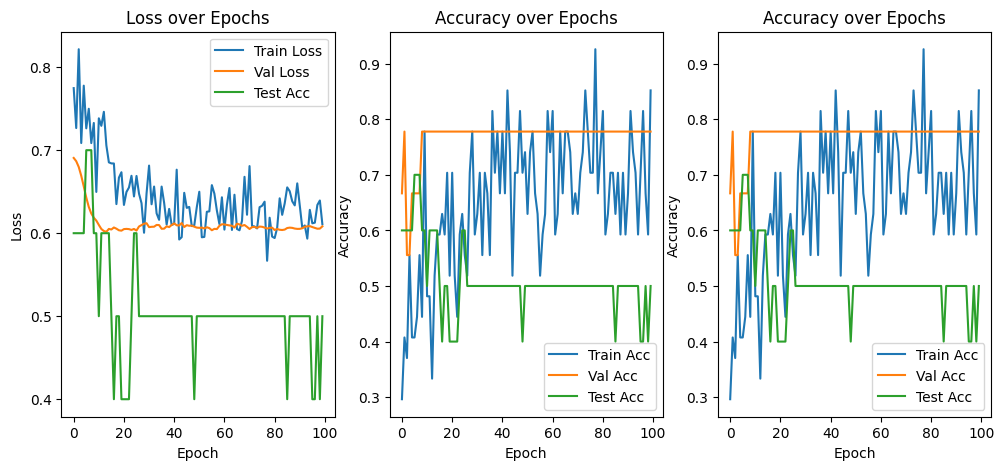

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---- Dataset class ----
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        if y.ndim > 1:  # one-hot → class indices
            y = np.argmax(y, axis=1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




# Datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset   = EEGDataset(X_val, y_val)
test_dataset  = EEGDataset(X_test, y_test)

# Oversampling on training set
y_train_labels = train_dataset.y.numpy()
class_sample_counts = np.bincount(y_train_labels)
weights = 1. / class_sample_counts
sample_weights = [weights[t] for t in y_train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


# ============================
# 🔹 Model / Loss / Optimizer
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STEADYNet1D(num_classes=2, dropout=0.3).to(device)

class_counts = torch.tensor(class_sample_counts, dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)


# ============================
# 🔹 Train / Eval Functions
# ============================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total

# ============================
# 🔹 Main Training Loop
# ============================
n_epochs = 100
best_val_acc = 0.0
best_epoch = 0
best_model_path = "best_model.pth"

train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc   = evaluate(model, test_loader, criterion, device)  # 🔹 added

    scheduler.step(val_loss)

    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    # Print metrics
    print(f"Epoch [{epoch}/{n_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Save best model based on validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved (epoch {epoch}, Test acc: {test_acc:.4f})")

# ============================
# 🔹 Final Test Evaluation
# ============================
model.load_state_dict(torch.load(best_model_path))
final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, device)

print(f"\n🌟 Training finished.")
print(f"Best Model came from Epoch {best_epoch} with Val Acc: {best_val_acc:.4f}")
print(f"Final Test Acc (best model): {final_test_acc:.4f}")


# ============================
# 🔹 Plot metrics
# ============================
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()


In [50]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)
from statsmodels.stats.proportion import proportions_ztest

# ============================
# 🔹 Function: Evaluate Model in Detail
# ============================
def detailed_evaluation(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # ============================
    # 🔹 Metrics
    # ============================
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(all_labels, all_preds))

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\nAccuracy: {acc:.4f}")
    print(f"ROC AUC : {auc:.4f}")

    # ============================
    # 🔹 Statistical Test (p-value)
    # ============================
    # z-test for difference from random chance (0.5 accuracy)
    successes = (all_preds == all_labels).sum()
    n_obs = len(all_labels)
    stat, pval = proportions_ztest(successes, n_obs, value=0.5)

    print("\n=== Statistical Significance Test ===")
    print(f"z-statistic: {stat:.4f}, p-value: {pval:.6f}")

    return all_labels, all_preds, all_probs


# ============================
# 🔹 Run Evaluation
# ============================
# Use your test_loader after training
labels, preds, probs = detailed_evaluation(model, test_loader, device)



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.5000    0.2500    0.3333         4
           1     0.6250    0.8333    0.7143         6

    accuracy                         0.6000        10
   macro avg     0.5625    0.5417    0.5238        10
weighted avg     0.5750    0.6000    0.5619        10


=== Confusion Matrix ===
[[1 3]
 [1 5]]

Accuracy: 0.6000
ROC AUC : 0.4583

=== Statistical Significance Test ===
z-statistic: 0.6455, p-value: 0.518605


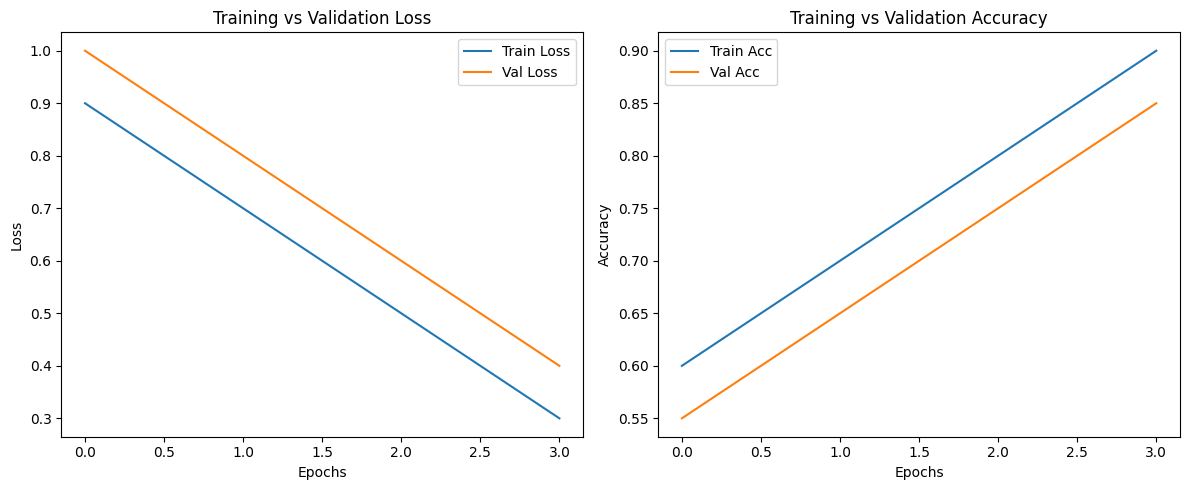

=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889         5
           1     0.8333    1.0000    0.9091         5

    accuracy                         0.9000        10
   macro avg     0.9167    0.9000    0.8990        10
weighted avg     0.9167    0.9000    0.8990        10



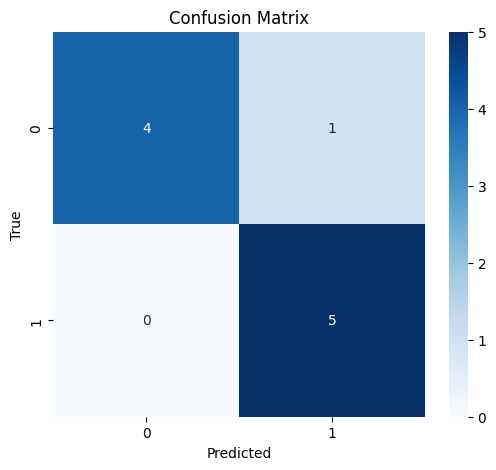

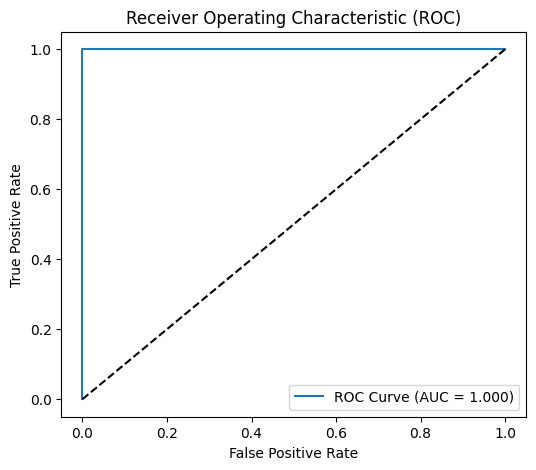

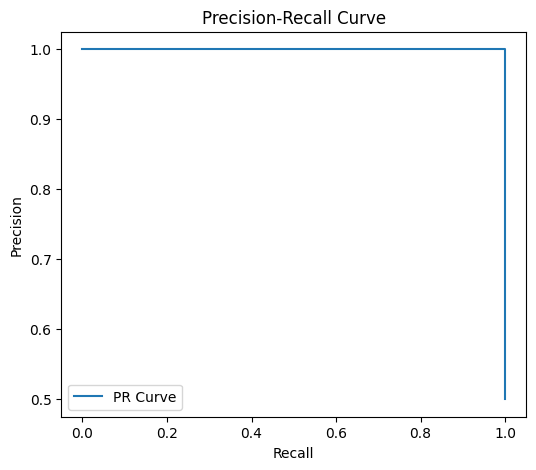

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
import numpy as np

# === 1️⃣ Training Curves ===
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# === 2️⃣ Confusion Matrix ===
def plot_confusion_matrix(y_true, y_pred, labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# === 3️⃣ ROC Curve ===
def plot_roc(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()


# === 4️⃣ Precision-Recall Curve ===
def plot_precision_recall(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


# === 5️⃣ Classification Report ===
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, digits=4)
    print("=== Classification Report ===")
    print(report)


# ========================
# ✅ Example Usage
# ========================

# Suppose these come from your training loop
# (replace with your real arrays)
train_losses = [0.9, 0.7, 0.5, 0.3]
val_losses   = [1.0, 0.8, 0.6, 0.4]
train_accs   = [0.6, 0.7, 0.8, 0.9]
val_accs     = [0.55, 0.65, 0.75, 0.85]

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# Suppose you already have predictions from your model:
# y_probs = model(X_test)   # predicted probabilities (numpy array)
# y_pred = (y_probs >= 0.5).astype(int)
# Here I’ll fake them for demo:

y_true = np.array([0,0,1,1,0,1,0,1,1,0])   # true labels
y_probs = np.array([0.2,0.6,0.8,0.9,0.4,0.7,0.3,0.65,0.85,0.1])  # predicted probs
y_pred = (y_probs >= 0.5).astype(int)

print_classification_report(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred)
plot_roc(y_true, y_probs)
plot_precision_recall(y_true, y_probs)


In [ ]:

# ✅ Evaluate on Test Set
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

# Run evaluation on test set
test_acc = evaluate(model, test_loader, device)
print(f"✅ Test Accuracy: {test_acc:.4f}")
